In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.inspection import DecisionBoundaryDisplay

In [174]:
'''
# Génération de données en 2D
X, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))
X2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)
X = np.vstack((X, X2))
y = np.zeros(X.shape[0])
print("Shape de X: ", X.shape)
print("Centroides: \n", centers)

# Affichage des données
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'g^', )
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')


plt.show()
'''

'\n# Génération de données en 2D\nX, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))\nX2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)\nX = np.vstack((X, X2))\ny = np.zeros(X.shape[0])\nprint("Shape de X: ", X.shape)\nprint("Centroides: \n", centers)\n\n# Affichage des données\nplt.plot(X[:, 0][y==1], X[:, 1][y==1],\'g^\', )\nplt.plot(X[:, 0][y==0], X[:, 1][y==0], \'g^\')\n\n\nplt.show()\n'

centers:  [[-16.24620532   7.27543845]
 [ 13.13584851   7.71349803]
 [  6.49702119 -19.58523971]
 [-19.47709533 -13.41376364]]


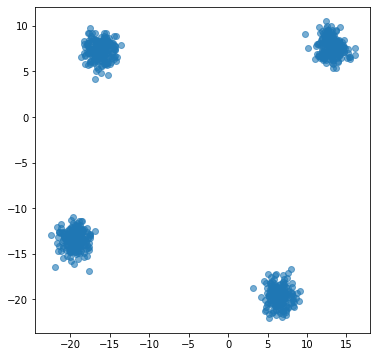

In [175]:
def generate_spheres(nb_clusters, nb_points, nb_dim, radius):
    X = np.zeros((nb_clusters*nb_points, nb_dim))
    y = np.zeros(nb_clusters*nb_points)
    centers = np.zeros((nb_clusters, nb_dim))
    for i in range(nb_clusters):
        # Générer un centre aléatoire
        centers[i] = np.random.uniform(-radius, radius, nb_dim)
        # Générer des points autour du centre
        X[i*nb_points:(i+1)*nb_points, :] = np.random.normal(centers[i], 1, (nb_points, nb_dim))
        # Affecter le label du cluster
        y[i*nb_points:(i+1)*nb_points] = i
    return X, y, centers

X, y, centers = generate_spheres(4, 200, 2, 20)
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
print("centers: ", centers)

# 1.1 C-moyennes floues

In [176]:
def c_moy_floue_apprentissage(X, nb_clusters, nb_iter=10, m=2):
    nb_points = X.shape[0]
    nb_dim = X.shape[1]
    # Initialisation des centres des clusters
    ind = np.random.randint(0,X.shape[0], nb_clusters)
    W = X[ind, :]
    eps = 10e-8
    print("Centres initiaux: \n", W)
    # Initialisation des distances entre les points et les centres des clusters
    D = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            D[i, j] = np.linalg.norm(X[i] - W[j])
    #  Initialisation des degrés d'appartenance des points aux clusters
    U = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            U[i, j] = 1 / (np.sum((D[i, j] / (D[i, :]+eps)) ** (2 / (m - 1)))+eps)
    # Boucle principale
    for t in range(nb_iter):
        # Mise à jour des centres des clusters
        for j in range(nb_clusters):
            W[j] = np.sum(U[:, j] ** m * X.T, axis=1) / np.sum(U[:, j] ** m)
        # Mise à jour des distances
        for i in range(nb_points):
            for j in range(nb_clusters):
                D[i, j] = np.linalg.norm(X[i] - W[j])

        # Mise à jour des degrés d'appartenance
        for i in range(nb_points):
            for j in range(nb_clusters):
                U[i, j] = 1 / np.sum((D[i, j] / D[i, :]) ** (2 / (m - 1)))

    return W, U

Centres initiaux: 
 [[-16.44681343   7.27460035]
 [-18.56084399 -13.739609  ]
 [ 12.24746911   8.76639947]
 [ 15.16089482   7.44939113]]
Centres finaux: 
 [[-16.23210334   7.29602136]
 [-19.42327462 -13.4062283 ]
 [ 13.07962891   7.72983552]
 [  6.44483594 -19.62680952]]


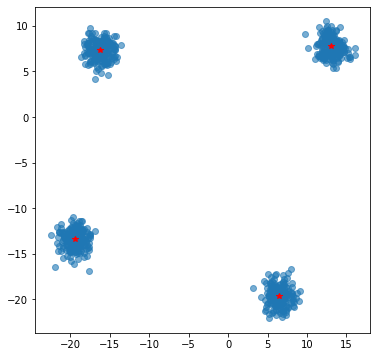

In [177]:
W,U = c_moy_floue_apprentissage(X, 4, nb_iter = 100, m=2)
print("Centres finaux: \n", W)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W[:, 0], W[:, 1], 'r*')
plt.show()



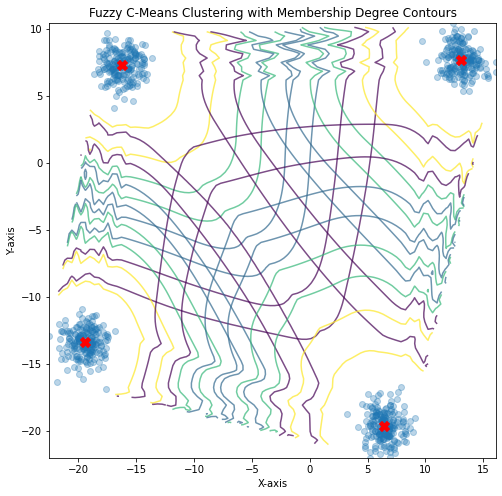

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap

def plot_fuzzy_cmeans_contours(X, W, U, figsize=(8, 8), resolution=100):
    """
    Plots the data points, centroids of the fuzzy c-means clusters, and the membership degree contours for each cluster.

    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param W: Centroids of clusters, numpy array of shape (n_clusters, n_features).
    :param U: Membership degrees, numpy array of shape (n_samples, n_clusters).
    :param figsize: Size of the figure (width, height) in inches.
    :param resolution: Resolution for the meshgrid used in contour plots.
    """
    plt.figure(figsize=figsize)

    # Create a meshgrid for the contour plots
    x_min, y_min = np.min(X, axis=0)
    x_max, y_max = np.max(X, axis=0)
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)

    # Create a custom colormap
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, W.shape[0])))

    # Plot contours for each cluster
    for j in range(W.shape[0]):
        # Interpolate membership degrees for cluster j
        Z = griddata(X, U[:, j], (X_mesh, Y_mesh), method='cubic')

        # Plot the membership degree contours for cluster j
        contour = plt.contour(X_mesh, Y_mesh, Z, levels=np.linspace(0, 1, 10), cmap=cmap, alpha=0.7)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha =0.3)
    plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')

    # Labeling the plot
    plt.title("Fuzzy C-Means Clustering with Membership Degree Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    plt.show()

# Example usage
# Assuming W and U are the outputs of your fuzzy c-means function for dataset X
plot_fuzzy_cmeans_contours(X, W, U)


In [179]:
def c_moy_floue_probabiliste(X,eta, W, nb_clusters, nb_iter=10, m=2):
    nb_points = X.shape[0]
    nb_dim = X.shape[1]
    print("Centres initiaux: \n", W)
    # Initialisation des distances entre les points et les centres des clusters
    D = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            D[i, j] = np.linalg.norm(X[i] - W[j])
    #  Initialisation des degrés d'appartenance des points aux clusters
    U = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            U[i, j] = 1 / 1 + ((D[i, j] / eta[j])** (2 / (m - 1)))


    # Boucle principale
    for t in range(nb_iter):
        # Mise à jour des centres des clusters
        for j in range(nb_clusters):
            W[j] = np.sum(U[:, j] ** m * X.T, axis=1) / np.sum(U[:, j] ** m)
            
        # Mise à jour des distances
        for i in range(nb_points):
            for j in range(nb_clusters):
                D[i, j] = np.linalg.norm(X[i] - W[j])

        # Mise à jour des degrés d'appartenance
        for i in range(nb_points):
            for j in range(nb_clusters):
                U[i, j] = 1 / 1 + ((D[i, j] / eta[j])** (2 / (m - 1)))

    return W, U

Centres initiaux: 
 [[ 11.95210276   9.37883503]
 [-17.47906221   7.47432177]
 [ 13.49243771   7.85103029]
 [-17.38522083   6.09956184]]
Centres initiaux: 
 [[  6.44483594 -19.62680952]
 [-16.23210334   7.29602136]
 [ 13.07962891   7.72983552]
 [-19.42327462 -13.4062283 ]]
Centres finaux: 
 [[  4.84162817 -11.26881583]
 [-13.83207561   0.20410821]
 [  9.99003018   2.82930591]
 [-15.2276138   -9.25979222]]


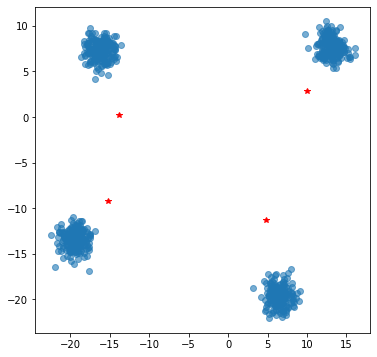

In [180]:
nb_clusters =4
eta = np.ones((nb_clusters))*2.5
W1,U1 = c_moy_floue_apprentissage(X, nb_clusters, nb_iter = 100, m=2)
#ind = np.random.randint(0,X.shape[0], nb_clusters)
#W = X[ind, :]
W2,U2 = c_moy_floue_probabiliste(X,eta,W1, nb_clusters, nb_iter = 2, m=2)
print("Centres finaux: \n", W2)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W2[:, 0], W2[:, 1], 'r*')
plt.show()


In [191]:
import numpy as np

def pcm(X, nb_clusters, eta, nb_iter=100, m=2):
    """
    Possibilistic c-means clustering algorithm.

    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param nb_clusters: The number of clusters to form.
    :param eta: Typicality parameters for each cluster, numpy array of shape (nb_clusters,).
    :param nb_iter: Number of iterations to run.
    :param m: Fuzziness parameter.
    :return: Tuple (W, U) where W is an array of centroids and U is the matrix of typicalities.
    """
    nb_points, nb_dim = X.shape

    # Initialize cluster centers randomly from data points
    indices = np.random.choice(nb_points, nb_clusters, replace=False)
    W = X[indices, :]

    # Initialize the matrix of typicalities
    U = np.random.rand(nb_points, nb_clusters)
    U = U / np.sum(U, axis=1, keepdims=True)

    for iteration in range(nb_iter):
        # Update typicalities U
        for i in range(nb_points):
            for j in range(nb_clusters):
                dist = np.linalg.norm(X[i] - W[j])
                U[i, j] = 1 / (1 + (dist / eta[j]) ** (2 / (m - 1)))

        # Update cluster centers W
        for j in range(nb_clusters):
            numerator = np.sum(U[:, j] ** m * X.T, axis=1)
            denominator = np.sum(U[:, j] ** m)
            W[j] = numerator / denominator

        # Optional: Implement convergence check to break the loop if clusters do not change significantly

    return W, U

nb_clusters = 4
eta = np.array([1.5 for _ in range(nb_clusters)])  # Define eta for each cluster
W, U = pcm(X, nb_clusters=nb_clusters, eta=eta)
print("Centres finaux: \n", W)
print("Typicalités finales: \n", U)

Centres finaux: 
 [[  6.40581567 -19.65830569]
 [-19.37497803 -13.35893041]
 [-19.37497803 -13.35893041]
 [ 13.10449095   7.7355985 ]]
Typicalités finales: 
 [[0.0017453  0.00521701 0.00521701 0.00242468]
 [0.00175224 0.00481396 0.00481396 0.0025889 ]
 [0.00161107 0.00437097 0.00437097 0.00242113]
 ...
 [0.00297861 0.72714049 0.72714049 0.00144196]
 [0.00321498 0.77250768 0.77250768 0.00146043]
 [0.00315217 0.97820172 0.97820172 0.00150072]]


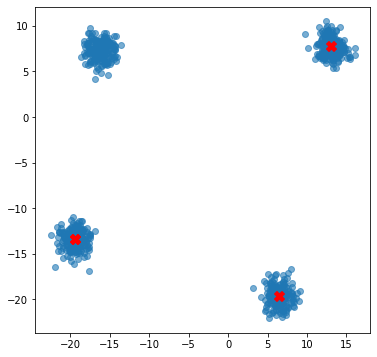

In [192]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')
plt.show()

In [182]:
km = KMeans(n_clusters=4, n_init=1, max_iter=100, tol=0.0001, random_state=0)
km.fit(X)
print("Inertia: ", km.inertia_)
print("Centroides: \n", km.cluster_centers_)
print("Nombre d'itérations: ", km.n_iter_)

Inertia:  1607.1489648650809
Centroides: 
 [[  6.44487766 -19.62451725]
 [ 13.07896499   7.73015164]
 [-16.23146327   7.2939128 ]
 [-19.42473314 -13.40898442]]
Nombre d'itérations:  2


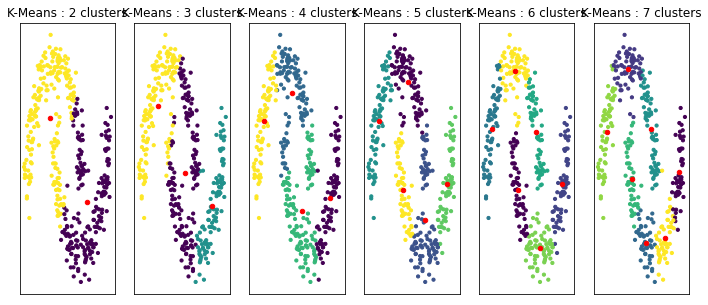

In [164]:
# Algorithms to compare
n_clusters_list = [2,3,4, 5, 6,7]
random_state = 0
clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(12, 5)
)

axs = axs.T

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters,n_init= 10,max_iter= 300, tol= 0.0001)
        algo.fit(X)
        centers = algo.cluster_centers_

        axs[j].scatter(X[:, 0], X[:, 1], s=10, c=algo.labels_)
        axs[j].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

        axs[j].set_title(f"{algorithm_name} : {n_clusters} clusters")


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

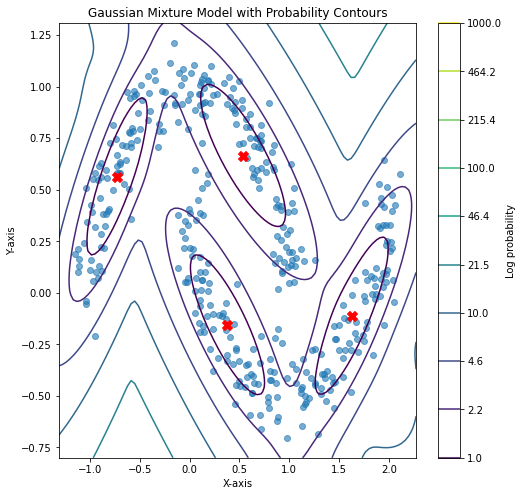

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4, n_init=10, max_iter=100, tol=0.0001, random_state=0)
gm.fit(X)

def plot_gmm_clusters_with_contours(gm, X, figsize=(8, 8), resolution=100):
    """
    Plots the data points, centroids of the GMM clusters, and the probability contours.

    :param gm: Fitted GaussianMixture object.
    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param figsize: Size of the figure (width, height) in inches.
    :param resolution: Resolution for the meshgrid used in contour plots.
    """
    plt.figure(figsize=figsize)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='red', s=100, marker='X')

    # Create a meshgrid for the contour plots
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], resolution)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)
    XX = np.array([X_mesh.ravel(), Y_mesh.ravel()]).T

    # Calculate the log probabilities for each point in the meshgrid
    Z = -gm.score_samples(XX)
    Z = Z.reshape(X_mesh.shape)

    # Plot the probability contours
    plt.contour(X_mesh, Y_mesh, Z, levels=np.logspace(0, 3, 10), norm=LogNorm(vmin=1.0, vmax=1000.0), cmap='viridis')

    # Labeling the plot
    plt.title("Gaussian Mixture Model with Probability Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.colorbar(label='Log probability')

    plt.show()

# Example usage
# Assuming gm is your fitted GaussianMixture model and X is your data
plot_gmm_clusters_with_contours(gm, X)


In [166]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=400, shuffle = True, noise=0.1)

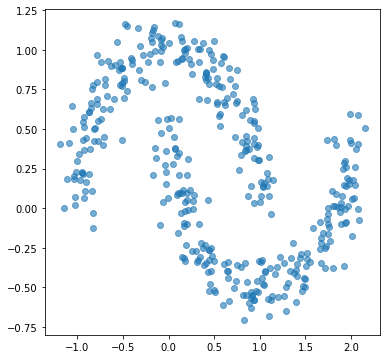

In [167]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)

Centres initiaux: 
 [[-0.32851258  0.87416623]
 [ 0.96933591  0.38450729]]
Centres finaux: 
 [[-0.23194814  0.5992535 ]
 [ 1.24765184 -0.09820607]]


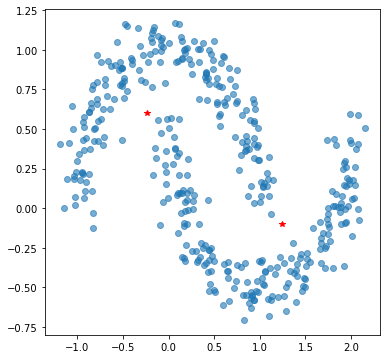

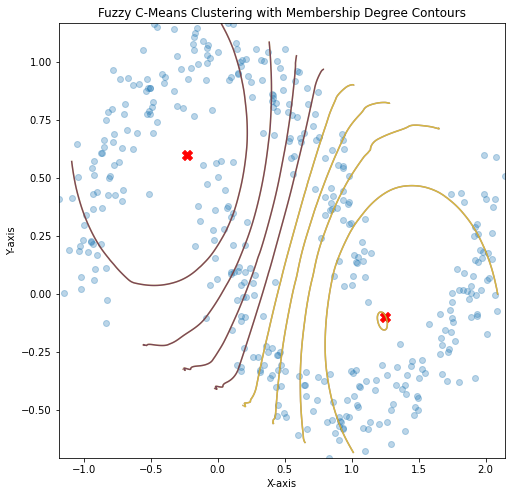

In [168]:
W,U = c_moy_floue_apprentissage(X, 2, nb_iter = 100, m=2)
print("Centres finaux: \n", W)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W[:, 0], W[:, 1], 'r*')
plt.show()
plot_fuzzy_cmeans_contours(X, W, U, figsize=(8, 8), resolution=1000)